In [1]:
# Image type matrix completion
# Loss fixed points
import csv
from collections import namedtuple
import enum
from MinPy import demo, loss as lossm, net, reg
import torch
from MinPy.toolbox import dataloader, plot, pprint
import numpy as np


device = 'cuda' if torch.cuda.is_available() else 'cpu'


rng = np.random.RandomState(seed=20210909)

Shape = namedtuple('Shape', ['rows', 'cols'])
Regularizer = namedtuple('RegularizerSet', ['weight_decay', 'regularizer', 'optimizer'])


def csv_to_tensor(csv_path):
    with open(csv_path) as f:
        reader = csv.reader(f, delimiter=',')
        rows = []
        for row in reader:
            rows.append([float(f) for f in row])
    return torch.tensor(rows)


def write_csv(matrix, filename):
    np.savetxt(f'{filename}.csv', matrix, delimiter=',')

    
def get_bit_mask(matrix, rate):
    return torch.tensor(rng.random(matrix.shape) > rate).int().to(device)
    
    
def dirichlet_energy_regularization(weight_decay, dimension, similarity_type):
    regularizer = reg.DirichletEnergyRegularization(dimension, similarity_type).to(device)
    optimizer = torch.optim.Adam(regularizer.parameters())
    return Regularizer(weight_decay=weight_decay, regularizer=regularizer, optimizer=optimizer)


def paper_regularization(weight_decay, dimension, similarity_type):
    regularizer = reg.auto_reg(dimension, similarity_type)
    return Regularizer(weight_decay=weight_decay, regularizer=regularizer, optimizer=None)


def run_test(epochs, matrix_factor_dimensions, matrix, mask, regularizers=None):
    if not regularizers:
        regularizers = []

    model = net.MyDeepMatrixFactorization(matrix_factor_dimensions).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    model.train()
    height, width = matrix.shape

    nmae_losses = []
    for e in range(epochs):

        # Compute prediction error
        reconstructed_matrix = model(matrix * mask)
        loss = (
            lossm.mse(reconstructed_matrix, matrix, mask)
            + sum((r.weight_decay * r.regularizer(reconstructed_matrix) for r in regularizers), start=0)
        )

        # Backpropagation
        optimizer.zero_grad()
        for r in regularizers:
            r.optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        for r in regularizers:
            r.optimizer.step()

        nmae_losses.append(lossm.nmae(reconstructed_matrix, matrix, mask).detach().cpu().numpy())

        if e % 100 == 0:
            pprint.my_progress_bar(e, epochs, nmae_losses[-1])
        if e % 5000 == 0:
            plot.gray_im(reconstructed_matrix.cpu().detach().numpy())

    return reconstructed_matrix, nmae_losses


def run_paper_test(epochs, matrix_factor_dimensions, matrix, mask, regularizers=None):
    if not regularizers:
        regularizers = []

    dmf = demo.BasicDeepMatrixFactorization(matrix_factor_dimensions, [r.regularizer for r in regularizers]) # Define model

    eta = [r.weight_decay for r in regularizers]

    #Training model
    for ite in range(epochs):
        dmf.train(matrix, mu=1, eta=eta, mask_in=mask)

        if ite % 100 == 0:
#             pprint.my_progress_bar(e, epochs, nmae_losses[-1])
            pprint.progress_bar(ite, epochs, dmf.loss_dict) # Format the loss of the output training and print out the training progress bar

        if ite % 5000 == 0:
            plot.gray_im(dmf.net.data.cpu().detach().numpy()) # Display the training image, you can set parameters to save the image

    return dmf.net.data, dmf.loss_dict['nmae_test']
    


[ 97 190  56 239  77 202  24   9 147 137   3 220 186  79 227 152 146 153
 197   4 165 169 125 127 143 185 103  87  89 145  57  35 222 198 131  29
  90 142  43  15 170  18  22 188  88  53 187 159  68  34 218  51 221 233
 203  16  54 117 183 129  14 128 192 167 158  38  96 232  11   8 209 107
 196  60  10 191 102  78  26 162  37 157 141  36  64 181 177 123  72 235
 118  41 178 112 215  84 230 173 179  82  76  62  98  30  17 195 228 182
  95 113 234 226  28 223 208 199  46  42 134  21  85  40   6 236  45  73
 156 210 204 217 101 166  31  71 139   5 149  92 130 174  50 194 108 138
 151   2 121 119 211  19  52  86  49 193 105  20 133 111 213  67  32 163
  13 124  59 115  55 172 135 219   1  44 100 126 155  63 116 140 122  75
 168 201 212 189  61  39 120 106 237  27  66  69  47 104  74 224 161 200
 109 132  70 175 144  81 160  94 231  99 205  80   0 180 229 225  91  25
 171  65  12  33 150 164 154 216 214  58   7  83 207  48 110 114 184  23
 148 136 176 238 206  93]
loss_fid:4.7e+01,nmae_tes

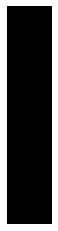

loss_fid:0.2,nmae_test:0.02, loss_all:0.67. Trainning progress: 25.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋

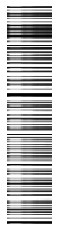

loss_fid:0.093,nmae_test:0.013, loss_all:0.14. Trainning progress: 50.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

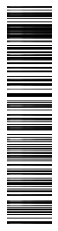

loss_fid:0.082,nmae_test:0.013, loss_all:0.09. Trainning progress: 75.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

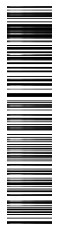

loss_fid:0.08,nmae_test:0.013, loss_all:0.083. Trainning progress: 1e+02 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

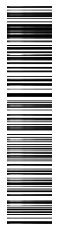

loss: 0.17. Trainning progress: 0.0%:  

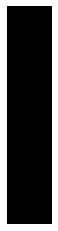

loss: 0.012. Trainning progress: 25.0%:  ▋▋▋▋▋▋▋▋▋▋▋▋

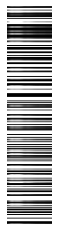

loss: 0.012. Trainning progress: 50.0%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

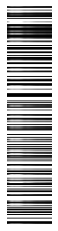

loss: 0.013. Trainning progress: 75.0%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

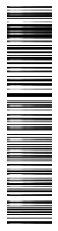

loss: 0.012. Trainning progress: 1e+02%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

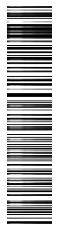

In [2]:
stacked_velocity_data = csv_to_tensor('./amir/vel_2Daneu_crop.csv').to(device)
rng = np.random.RandomState(seed=20210909)
row_indices = rng.permutation(240)
print(row_indices)
matrix = stacked_velocity_data[row_indices]
# matrix = stacked_velocity_data
# matrix = dataloader.get_data(height=240,width=240,pic_name='./train_pics/Barbara.jpg').to(device)
mask_rate = 0.9
mask = get_bit_mask(matrix, rate=mask_rate)
rows, cols = matrix.shape
matrix_factor_dimensions = [
    Shape(rows=rows, cols=rows),
    Shape(rows=rows, cols=rows),
    Shape(rows=rows, cols=rows),
    Shape(rows=rows, cols=cols)
]
epochs = 20_001
RCMatrix_PaperDMFAIR, PaperDMFAIR_losses = run_paper_test(epochs, matrix_factor_dimensions, matrix, mask, regularizers=[
    paper_regularization(1e-5, rows, 'row'),
    paper_regularization(1e-5, cols, 'col')
])
RCMatrix_MyDMF, MyDMF_losses = run_test(epochs, matrix_factor_dimensions, matrix, mask)
# RCMatrix_MyDMFAIR, MyDMFAIR_losses = run_test(epochs, matrix_factor_dimensions, matrix, mask, regularizers=[
#     dirichlet_energy_regularization(1e-5, rows, reg.DirichletEnergyRegularizationMode.ROW_SIMILARITY),
#     dirichlet_energy_regularization(1e-5, cols, reg.DirichletEnergyRegularizationMode.COL_SIMILARITY)
# ])

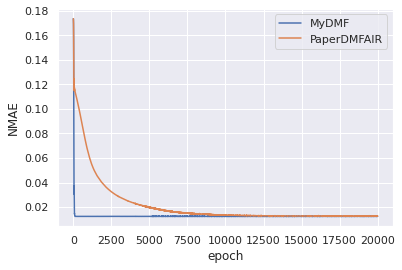

In [3]:
RCMatrices = {
    'MyDMF': (MyDMF_losses, RCMatrix_MyDMF),
#     'MyDMFAIR': (MyDMFAIR_losses, RCMatrix_MyDMFAIR),
    'PaperDMFAIR': (PaperDMFAIR_losses, RCMatrix_PaperDMFAIR)
}
losses = {n: t[0] for n, t in RCMatrices.items()}
losses['x_plot'] = np.arange(0, epochs, 1)
plot.lines(losses, save_if=False, black_if=True, ylabel_name='NMAE')
matrices = {n: t[1] for n, t in RCMatrices.items()}
for fn, m in matrices.items():
    write_csv(m.cpu().detach().numpy(), f'{fn}_{mask_rate}')

In [4]:
RCMatrices = {
    f'MyDMF_{mask_rate}',
#     f'MyDMFAIR_{mask_rate}',
    f'PaperDMFAIR_{mask_rate}'
}
ground_truth = 'amir/vel_2Daneu_crop'
row_index_matrices = {
    ground_truth,
    f'amir/vel2Daneu_crop_recovered_{mask_rate}'
}
tensor_dict = {n: csv_to_tensor(f'{n}.csv') for n in row_index_matrices.union(RCMatrices)}
index_to_rows = {}
for i in range(row_indices.shape[0]):
    index_to_rows[i] = {}
    for n, t in tensor_dict.items():
        row = t[row_indices[i]] if n in row_index_matrices else t[i]
        index_to_rows[i][n] = row
index = 238
index = 1
to_plot = {n: y for n, y in index_to_rows[index].items()}
to_plot['x_plot'] = np.arange(0, index_to_rows[index][ground_truth].shape[0], 1)
plot.lines(to_plot, save_if=False, black_if=True, ylabel_name=f'vel_2Daneu_row_{row_indices[index]}')


error_dict = {}
for i, rows in index_to_rows.items():
    error_dict[i] = {}
    for n in rows.keys() - {ground_truth}:
        l2_error = torch.sum((rows[n] - rows[ground_truth])**2)
        error_dict[i][n] = l2_error

error_list = [rows for rows in error_dict.values()] # map
error_list_dict = {n: [] for n in error_list[0].keys()} # reduce init value
for rows in error_list: # reduce
    for n, e in rows.items():
        error_list_dict[n].append(e)
error_list_summed_dict = {n: np.sum(y) for n, y in error_list_dict.items()}
print(error_list_summed_dict)
error_to_plot = {n: np.array(y) for n, y in error_list_dict.items()}
error_bound = 600
error_to_plot_bounded = {n: np.minimum(np.array(y), error_bound) for n, y in error_list_dict.items()}
error_to_plot['x_plot'] = np.arange(0, row_indices.shape[0], 1)
error_to_plot_bounded['x_plot'] = np.arange(0, row_indices.shape[0], 1)
plot.lines(error_to_plot, save_if=False, black_if=True, ylabel_name='Error: vel_2Daneu')
plot.lines(error_to_plot_bounded, save_if=False, black_if=True, ylabel_name=f'Error (bounded: < {error_bound}): vel_2Daneu')

NameError: name 'line_dict' is not defined